# QSD Quantum Teleportation 
This notebook will cover quantum teleportation and implement qunatum teleportation circuit with 2 ancilla qubits. 
Here are the following packages needed: 

In [1]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import IBMQ, Aer, transpile
from qiskit.visualization import plot_histogram, plot_bloch_multivector, array_to_latex
from qiskit.extensions import Initialize
from qiskit.result import marginal_counts
from qiskit.quantum_info import random_statevector

### Circuits 
 Here we use two smaller circuits of preparing the bell state and bell measurement in order to implement a quantum teleportation circuit of distance 2. 

In [2]:
def create_prepare_bell_state():
    """Create a circuit that prepares two zeroed qubits into a bell state

    Sample Circuit:

         ┌───┐
    q_0: ┤ H ├──■──
         └───┘┌─┴─┐
    q_1: ─────┤ X ├
              └───┘

    :return: A new circuit that transforms |00> into (|00> + |11>)/sqrt(2)
    """
    circuit = QuantumCircuit(2)

    circuit.h(0)
    circuit.cnot(0, 1)

    return circuit

def create_bell_measurement():
    """Create a circuit that caries out a measurement in the bell basis

    Sample Circuit:

              ┌───┐ ░ ┌─┐
    q_0: ──■──┤ H ├─░─┤M├───
         ┌─┴─┐└───┘ ░ └╥┘┌─┐
    q_1: ┤ X ├──────░──╫─┤M├
         └───┘      ░  ║ └╥┘
    c: 2/══════════════╩══╩═
                       0  1

    :return: A new circuit that measures against the bell basis
    """

    inverse_bell_state = create_prepare_bell_state().inverse()

    circuit = QuantumCircuit(2, 2)

    circuit.compose(inverse_bell_state, inplace=True)

    circuit.barrier((0, 1))

    circuit.measure(0, 0)
    circuit.measure(1, 1)

    return circuit

def create_teleportation():
    """
    Create a circuit that uses entanglement swapping to implement teleportation:
                         ┌───┐┌─┐               ┌───┐
    q0_0: ────────────■──┤ H ├┤M├───────────────┤ X ├────────────────────────────
          ┌───┐     ┌─┴─┐└┬─┬┘└╥┘   ┌───┐       └─╥─┘
    q0_1: ┤ H ├──■──┤ X ├─┤M├──╫────┤ X ├─────────╫──────────────────────────────
          └───┘┌─┴─┐└───┘ └╥┘  ║    └─╥─┘         ║         ┌───┐       ┌───┐
    q0_2: ─────┤ X ├───────╫───╫──────╫───────────╫─────────┤ X ├───────┤ Z ├────
               └───┘       ║   ║      ║           ║         └─╥─┘       └─╥─┘
                           ║   ║ ┌────╨─────┐┌────╨─────┐┌────╨─────┐┌────╨─────┐
    c0: 2/═════════════════╩═══╩═╡ c0_1=0x1 ╞╡ c0_0=0x1 ╞╡ c0_1=0x1 ╞╡ c0_0=0x1 ╞
                           1   0 └──────────┘└──────────┘└──────────┘└──────────┘
    """


    qr = QuantumRegister(3, name="q")    
    crz = ClassicalRegister(1, name="crz")
    crx = ClassicalRegister(1, name="crx") 
    circuit = QuantumCircuit(qr, crz, crx)

    prepare_bell_state = create_prepare_bell_state()
    inverse_bell_state = prepare_bell_state.inverse()

    circuit.compose(prepare_bell_state, qubits=(1, 2), inplace=True)

    circuit.compose(inverse_bell_state, qubits=(0, 1), inplace=True)

    num_ancilla = 2
    for i in range(0, num_ancilla):
        circuit.measure(i, i)

    circuit.x(2).c_if(crx, 1) 
    circuit.z(2).c_if(crz, 1)

    return circuit

Demonstration of the teleportation circuit using two ancilla (the simple case)

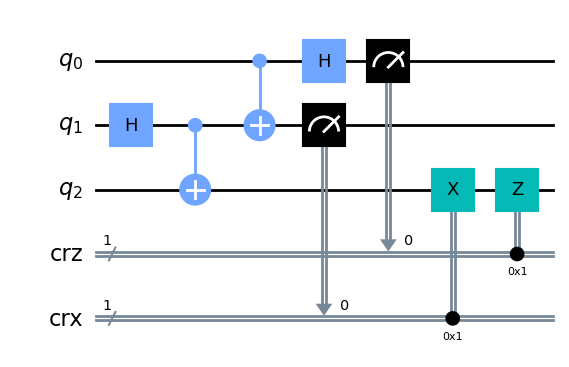

In [3]:
qc = create_teleportation()
qc.draw('mpl')

# Testing and simulating Quantum Teleportation
Now will we simulate the Quantum Teleportation circuit with a random state $$| \psi \rangle$$ and then test to see if the state was correctly moved. 
First we will create a random state vector and then display it. 

<IPython.core.display.Latex object>

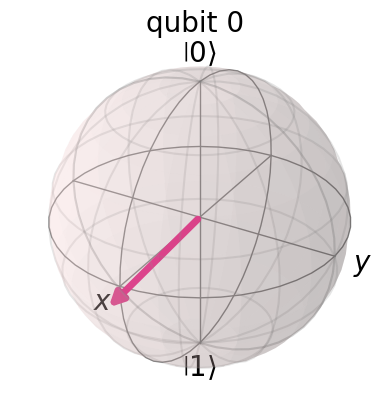

In [4]:
psi = random_statevector(2) 
display(array_to_latex(psi, prefix= " |\\psi\\rangle = "))
plot_bloch_multivector(psi)

Now we will create the teleportation circuit that teleports this random state vector over 2 ancilla qubits and draw it

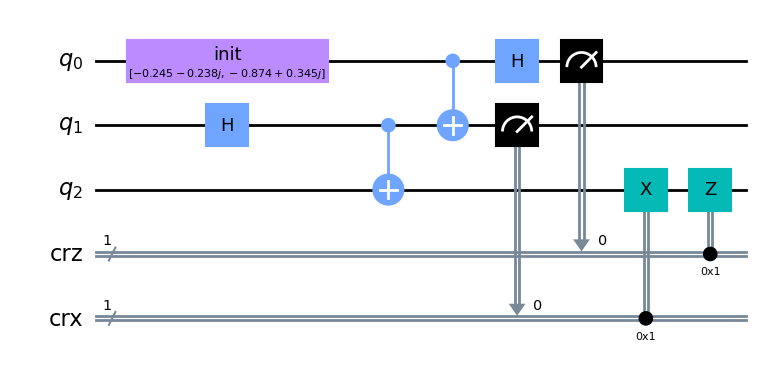

In [5]:
qc_orig = QuantumCircuit(3)
init_gate = Initialize(psi)
init_gate.label = "init"
qc_orig.append(init_gate, [0]) 
qc_tele = create_teleportation()
qc = qc_orig.compose(qc_tele)
qc.draw('mpl')


Now confirming that the statevector at $q_2$ now contains the original statevector $|\psi \rangle$. We will do this using aer simulator to simulate the statevector

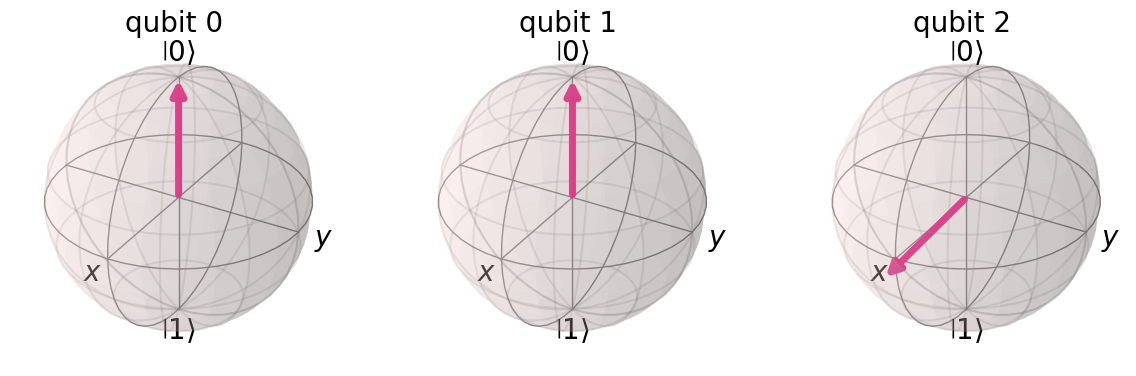

In [6]:
qc_copy = QuantumCircuit(3)
qc_copy = qc_copy.compose(qc)
sim = Aer.get_backend('aer_simulator')
qc_copy.save_statevector()
result_vec = sim.run(qc_copy).result().get_statevector()
plot_bloch_multivector(result_vec)

Here we can see the values that Bob measured for the two qubits and thus we can compute what gates he used, but more importantly, we see that the state of qubit 2 is identical to $|\psi \rangle$ as seen with the bloch sphere before. Thus our implementation of quantum teleportation has successfully transferred the state of qubit 0 to qubit 2. 

Now we can run this simulation many times to further confirm that the teleportation is always working. But before we do so, we need to apply a disentangle and measure qubit 2.

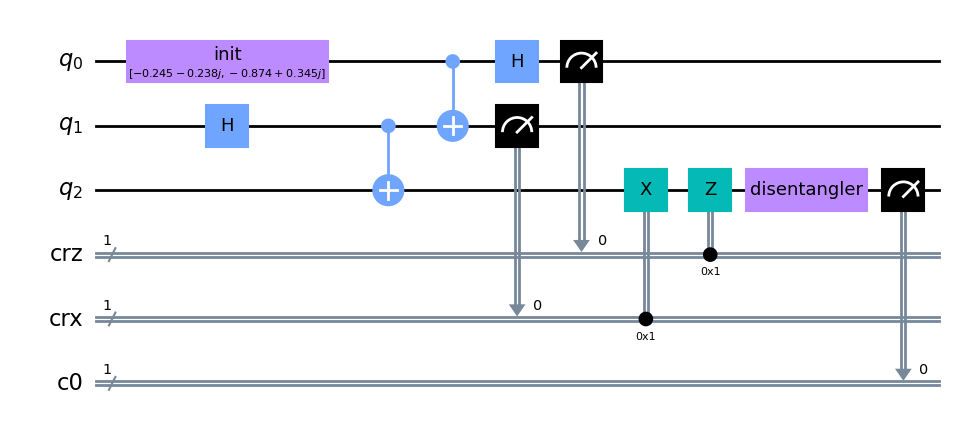

In [7]:
inverse_init_gate = init_gate.gates_to_uncompute()
cr_res = ClassicalRegister(1)
qc.add_register(cr_res)
qc.append(inverse_init_gate, [2])
qc.measure(2,2)
qc.draw('mpl')

Now running the experiment

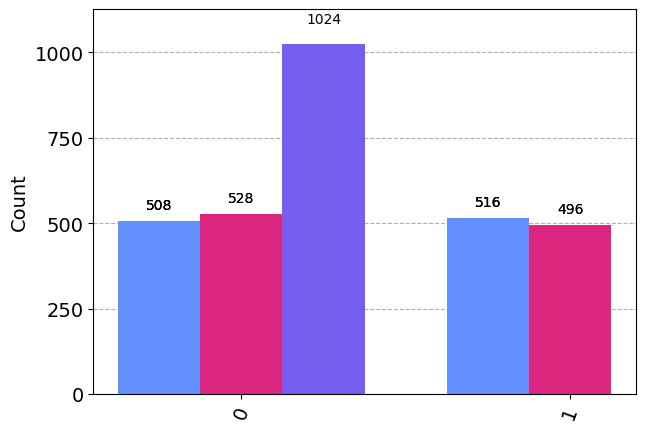

In [8]:
t_qc = transpile(qc, sim)
t_qc.save_statevector()
counts = sim.run(t_qc).result().get_counts()
qubit_counts = [marginal_counts(counts, [qubit]) for qubit in range(3)]
plot_histogram(qubit_counts)

Note that we ran the experiment 1024 times, and from the purple bar, we see that each time, we successfully obtained the state $\psi$ in qubit 2 after the quantum teleportation.

To see what the results would look like on a real quantum computer, we will run the job on one of IBM's fake_provider that mimics how the actual quantum system performs. Note that we are not running it on a real quantum computer as running jobs takes a while

In [9]:
from qiskit.providers.fake_provider import FakeManilaV2
from qiskit import transpile

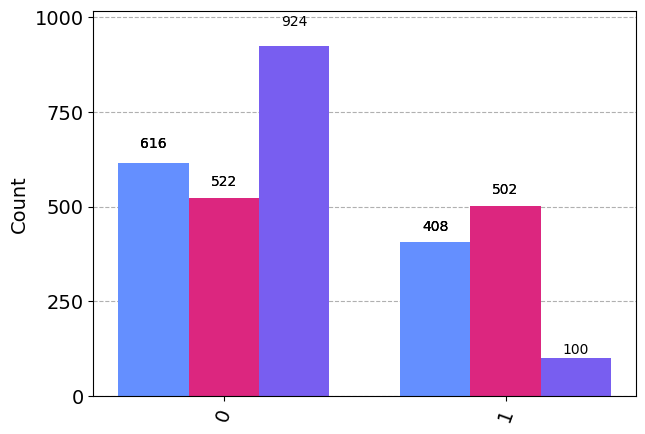

In [10]:

backend = FakeManilaV2()
job = backend.run(t_qc)
exp_result = job.result()
exp_counts = exp_result.get_counts(qc)
qubit_counts = [marginal_counts(exp_counts, [qubit]) for qubit in range(3)]
plot_histogram(qubit_counts)


Here we see that the quantum teleportation is no longer 100% accurate as each gate in the circuit now has some error.